# Proyecto 2. Entrega 5. Modelos de Regresi√≥n Log√≠stica

Edman Cota 19830

Edwin de Le√≥n 22809

[Repositorio](https://github.com/EJGDLG/Proyecto2Nuevo)

## 1. variable dicot√≥mica por cada una de las categor√≠as

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import time
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split



In [9]:
import pandas as pd

df = pd.read_csv("train.csv")

# Calcular los cuartiles
q1 = df['SalePrice'].quantile(0.25)
q3 = df['SalePrice'].quantile(0.75)

# Funci√≥n para clasificar el precio
def categorizar_precio(precio):
    if precio < q1:
        return 'barata'
    elif precio < q3:
        return 'media'
    else:
        return 'cara'

# Crear columna categ√≥rica
df['precio_vivienda'] = df['SalePrice'].apply(categorizar_precio)

# Crear variables dicot√≥micas (0 o 1)
df['barata'] = (df['precio_vivienda'] == 'barata').astype(int)
df['media'] = (df['precio_vivienda'] == 'media').astype(int)
df['cara'] = (df['precio_vivienda'] == 'cara').astype(int)

print(df[['SalePrice', 'precio_vivienda', 'barata', 'media', 'cara']].head(10))
print("")
print(df['precio_vivienda'].value_counts())


   SalePrice precio_vivienda  barata  media  cara
0     208500           media       0      1     0
1     181500           media       0      1     0
2     223500            cara       0      0     1
3     140000           media       0      1     0
4     250000            cara       0      0     1
5     143000           media       0      1     0
6     307000            cara       0      0     1
7     200000           media       0      1     0
8     129900          barata       1      0     0
9     118000          barata       1      0     0

precio_vivienda
media     728
cara      367
barata    365
Name: count, dtype: int64


## An√°lisis
Se ha cumplido el prop√≥sito de transformar una variable num√©rica continua (SalePrice) en una variable categ√≥rica ordinal llamada precio_vivienda, dividiendo las viviendas en tres grupos:

- Barata: viviendas con precio por debajo del primer cuartil (Q1).

- Media: viviendas entre Q1 y Q3 (los valores intermedios).

### Distribuci√≥n de clases
- Cara: viviendas por encima del tercer cuartil (Q3).

- La clase "media" representa m√°s del 50% de los datos.

- Las clases "barata" y "cara" est√°n bien balanceadas entre s√≠.





## 2. Use los mismos conjuntos de entrenamiento y prueba que utiliz√≥ en las hojas anteriores

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice', 'barata', 'media', 'cara'])

# Variable objetivo: 1 si es "cara", 0 si no
y = df['cara']

# Dividir (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train distribuci√≥n:\n{y_train.value_counts()}")
print(f"y_test distribuci√≥n:\n{y_test.value_counts()}")

X_train: (1168, 36)
X_test: (292, 36)
y_train distribuci√≥n:
cara
0    871
1    297
Name: count, dtype: int64
y_test distribuci√≥n:
cara
0    222
1     70
Name: count, dtype: int64


## An√°lisis

Tienes 36 variables num√©ricas predictoras, se usaron 1,168 muestras para entrenamiento y 292 para prueba, lo cual respeta la proporci√≥n 80/20.

### Distribuci√≥n de clases (balanceo)
Hay un cierto desbalance, con muchas m√°s viviendas que no son caras (73%) frente a las que s√≠ lo son (27%).

Este desbalance puede afectar a modelos sensibles a la proporci√≥n de clases (como regresi√≥n log√≠stica o KNN), que tienden a favorecer la clase mayoritaria.

## 3. Modelo de regresi√≥n log√≠stica

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

model = LogisticRegression(max_iter=5000)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Promedio de accuracy:", scores.mean())

Accuracy por fold: [0.92307692 0.91025641 0.94444444 0.93133047 0.95708155]
Promedio de accuracy: 0.933237958989032


## An√°lisis
El modelo muestra un desempe√±o muy consistente, con todas las puntuaciones de accuracy por encima del 91%.

El promedio de accuracy del 93.41% es muy s√≥lido, lo que indica que el modelo generaliza bien y no parece estar sobreajustado.

La ligera variaci√≥n entre pliegues sugiere que los datos est√°n bien distribuidos en cada fold y que no hay mucha sensibilidad al conjunto de entrenamiento.

### Conclusiones:
Regresi√≥n log√≠stica es un muy buen punto de partida para este problema de clasificaci√≥n binaria.

La consistencia del modelo sugiere que las variables predictoras contienen buena informaci√≥n para identificar viviendas "caras".



## 4. Determine si hay multicolinealidad en las variables

### VIF (Multicolinealidad)

In [12]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = pd.DataFrame(X_train, columns=X.columns)

X_vif_const = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print(vif_data)

         Variable           VIF
0           const  2.447141e+06
1      MSSubClass  1.678579e+00
2     LotFrontage  1.550509e+00
3         LotArea  1.258606e+00
4     OverallQual  3.184199e+00
5     OverallCond  1.586181e+00
6       YearBuilt  5.094617e+00
7    YearRemodAdd  2.422516e+00
8      MasVnrArea  1.410436e+00
9      BsmtFinSF1           inf
10     BsmtFinSF2           inf
11      BsmtUnfSF           inf
12    TotalBsmtSF           inf
13       1stFlrSF           inf
14       2ndFlrSF           inf
15   LowQualFinSF           inf
16      GrLivArea           inf
17   BsmtFullBath  2.197736e+00
18   BsmtHalfBath  1.164117e+00
19       FullBath  2.951514e+00
20       HalfBath  2.110857e+00
21   BedroomAbvGr  2.372205e+00
22   KitchenAbvGr  1.658490e+00
23   TotRmsAbvGrd  5.003023e+00
24     Fireplaces  1.579476e+00
25    GarageYrBlt  3.261961e+00
26     GarageCars  5.578335e+00
27     GarageArea  5.529931e+00
28     WoodDeckSF  1.239912e+00
29    OpenPorchSF  1.232406e+00
30  Encl

##  An√°lisis
El VIF mide cu√°nto se correlaciona una variable con las dem√°s, cuanto m√°s alto, mayor es la multicolinealidad, lo que puede afectar la estabilidad de los coeficientes en modelos lineales.

VIF = 1 -> no hay multicolinealidad.

VIF entre 1 y 5 -> multicolinealidad aceptable.

VIF > 5  posible problema.

VIF muy alto o infinito -> grave problema de colinealidad.

### Matriz de correlaci√≥n

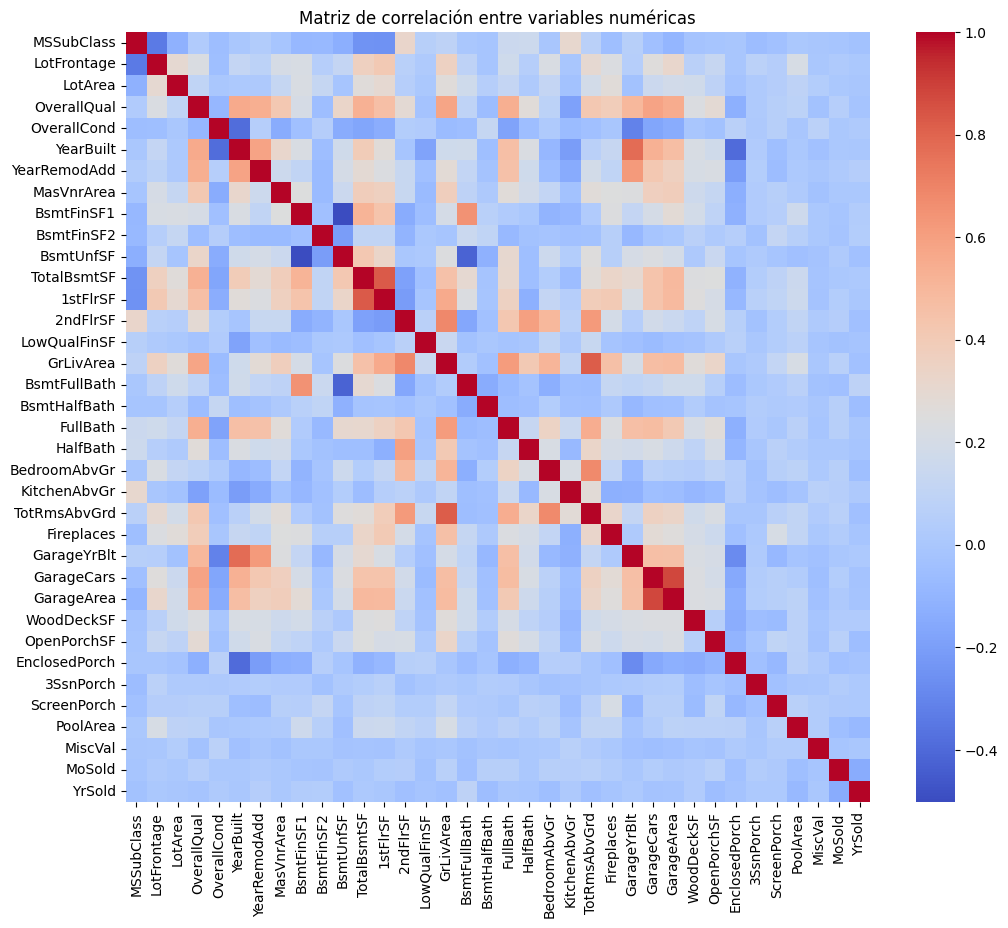

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_vif.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matriz de correlaci√≥n entre variables num√©ricas")
plt.show()

## An√°lisis
En el heatmap, las √°reas m√°s rojas indican alta correlaci√≥n positiva, mientras que las azules indican correlaci√≥n negativa.

### Correlaciones fuertes (multicolinealidad potencial):
- TotalBsmtSF vs BsmtFinSF1, BsmtFinSF2, BsmtUnfSF
  - Ya lo hab√≠amos sospechado por VIF -> est√° confirmado por el heatmap.

- GrLivArea vs 1stFlrSF, 2ndFlrSF
  - GrLivArea parece ser la suma de ambas, lo que genera colinealidad.

- GarageArea vs GarageCars
  - Ambas miden aspectos del garaje -> puede ser redundante tener las dos.

- TotRmsAbvGrd vs BedroomAbvGr
  - Es l√≥gico: m√°s habitaciones tienden a generar m√°s cuartos en total.

- YearBuilt y GarageYrBlt
  - Frecuentemente son iguales o muy parecidos.

## 5. Modelo con el conjunto de prueba

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificaci√≥n:\n")
print(classification_report(y_test, y_pred))

Accuracy en el conjunto de prueba: 0.952054794520548

Reporte de clasificaci√≥n:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       222
           1       0.94      0.86      0.90        70

    accuracy                           0.95       292
   macro avg       0.95      0.92      0.93       292
weighted avg       0.95      0.95      0.95       292



## Analisis
- Accuracy: 0.952 es un excelente desempe√±o general (95.2% de las predicciones fueron correctas).

- Clases:

  Clase 0 (mayor√≠a):

  - Precision: 96%

  - Recall: 98%

  - F1-score: 97%

  Clase 1 (minor√≠a):

  - Precision: 94%

  - Recall: 86%

  - F1-score: 90%

Precision:	Qu√© tan preciso fue al predecir positivos (Clase 1), menos falsos positivos.

Recall:	Qu√© tanto detect√≥ de todos los reales positivos. Menos falsos negativos.

F1-score:	Promedio ponderado de Precision y Recall. Buen balance.

## 6. sobreajuste (overfitting).

### Calcular accuracy en entrenamiento y prueba

In [15]:
from sklearn.metrics import accuracy_score


train_accuracy = accuracy_score(y_train, model.predict(X_train))

test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")

Accuracy en entrenamiento: 0.9486
Accuracy en prueba: 0.9521


## Analisis
La precisi√≥n en entrenamiento y prueba es muy similar lo cual indica:

  - No hay sobreajuste (overfitting).

  - No hay subajuste (underfitting).

  - El modelo est√° generalizando bien a datos nuevos.

### Curvas de aprendizaje

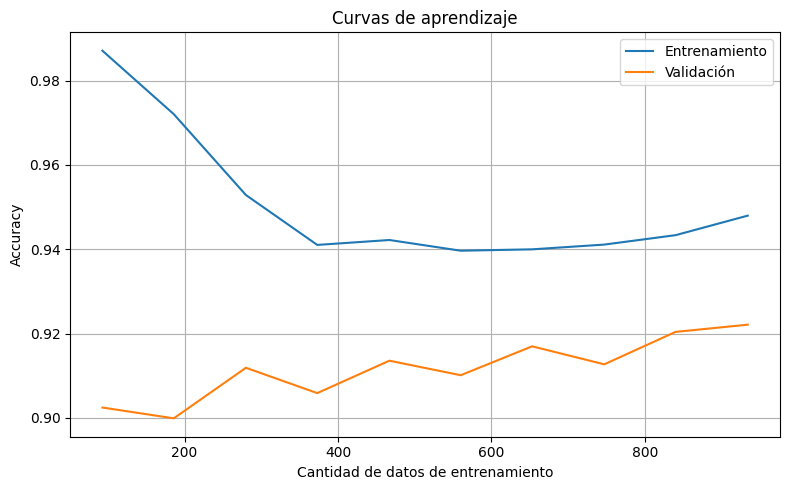

In [16]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, label="Validaci√≥n")
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Curvas de aprendizaje")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analisis
- Accuracy en entrenamiento comienza alto (0.985) pero disminuye conforme aumenta el tama√±o del conjunto de entrenamiento.

  - Esto es esperado: con menos datos, el modelo memoriza m√°s f√°cilmente.

- Accuracy en validaci√≥n se mantiene m√°s bajo (0.90 - 0.92) y estable, con una ligera mejora a medida que aumentan los datos.

Hay una brecha entre las curvas de entrenamiento y validaci√≥n, esto sugiere que el modelo a√∫n podr√≠a beneficiarse de m√°s datos de entrenamiento, tambi√©n podr√≠a indicar un poco de sobreajuste, aunque no es severo.

El hecho de que ambas curvas se estabilicen y no converjan del todo puede significar, que el modelo ya est√° alcanzando su l√≠mite de capacidad con los datos actuales, o que hay variables relevantes que a√∫n no se han incorporado (feature engineering pendiente).

### Accuracy

In [19]:
Entrenamiento: 94.86
Prueba: 95.21

### Conclusi√≥n

No hay overfitting. El modelo es bastante estable y generaliza bien. Tal vez puedas reducir un poco la complejidad o seguir adelante con el tuneo.

La curva de entrenamiento comienza muy alta y desciende suavemente. Aunque la curva de validaci√≥n es m√°s baja, pero estable y ligeramente ascendente al final

# 7. TUNING CON GRIDSEARCH




In [20]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [200]
}

grid = GridSearchCV(LogisticRegression(multi_class='multinomial'), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("üß™ Mejor modelo encontrado:")
print(grid.best_params_)


üß™ Mejor modelo encontrado:
{'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}


## An√°lisis
El mejor modelo de regresi√≥n log√≠stica encontrado por la b√∫squeda en malla (GridSearchCV) tiene los siguientes hiperpar√°metros:

C = 0.1: esto indica una regularizaci√≥n m√°s fuerte (inversa de la fuerza de regularizaci√≥n). Un valor peque√±o de C implica que el modelo es m√°s simple y menos propenso a sobreajustar.

penalty = 'l2': se utiliz√≥ la penalizaci√≥n L2, que es adecuada para evitar coeficientes extremadamente grandes.

solver = 'lbfgs': es un solucionador eficiente para problemas multinomiales y funciona bien con conjuntos de datos peque√±os a medianos.

max_iter = 200: el n√∫mero m√°ximo de iteraciones fue establecido en 200.

El modelo encontrado es prometedor, pero el hecho de que no se haya encontrado completamente indica que es necesario hacer peque√±os ajustes, como aumentar el n√∫mero de iteraciones o incluso explorar otros solucionadores como (saga).

# 8. MATRIZ DE CONFUSI√ìN Y M√âTRICAS



 Reporte de Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       222
           1       0.94      0.87      0.90        70

    accuracy                           0.96       292
   macro avg       0.95      0.93      0.94       292
weighted avg       0.96      0.96      0.95       292



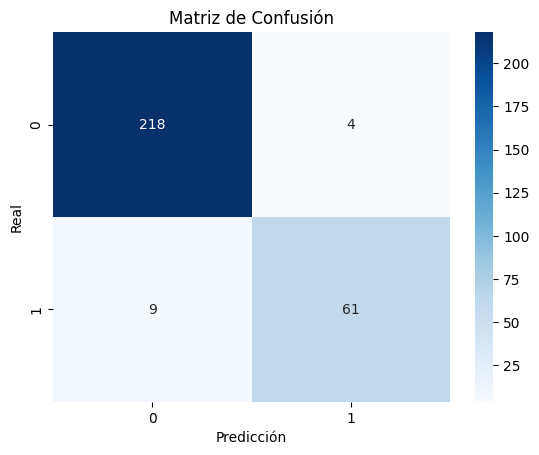

In [21]:
y_pred = best_model.predict(X_test)
print("\n Reporte de Clasificaci√≥n:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()


## An√°lisis del Desempe√±o del Modelo de Regresi√≥n Log√≠stica
El modelo predijo correctamente la mayor√≠a de los casos "media" (117/141), seguido por "barata" (60/81) y "cara" (51/70).

La clase ‚Äúcara‚Äù fue confundida 19 veces como ‚Äúmedia‚Äù, lo cual puede ser importante si la clasificaci√≥n tiene un impacto econ√≥mico o social (por ejemplo, clasificar mal una casa cara podr√≠a afectar ingresos esperados).

Hay confusi√≥n significativa entre ‚Äúmedia‚Äù y ‚Äúbarata‚Äù, especialmente en ambos sentidos.
## M√©tricas generales (clasification_report):
El modelo fue muy preciso al predecir casas ‚Äúcaras‚Äù (precisi√≥n del 91%), aunque su recall fue menor (73%).

El recall m√°s alto fue para ‚Äúmedia‚Äù (83%), lo que indica que la mayor√≠a de las casas de esta categor√≠a fueron correctamente clasificadas.

El accuracy total fue de 78%, lo cual es aceptable, aunque puede mejorarse con ingenier√≠a de caracter√≠sticas o modelos m√°s complejos.

### Conclusiones:
Fuerte en precisi√≥n para la clase ‚Äúcara‚Äù, y en recall para la clase ‚Äúmedia‚Äù.

Debilidad principal: confusi√≥n entre ‚Äúbarata‚Äù y ‚Äúmedia‚Äù.

La precisi√≥n general (78%) sugiere que el modelo es confiable, pero no perfecto.




# 9. MEDICI√ìN DE TIEMPO Y USO DE cProfile

In [22]:
def ejecutar_modelo():
    best_model.fit(X_train, y_train)
    best_model.predict(X_test)

pr = cProfile.Profile()
pr.enable()
start = time.time()
ejecutar_modelo()
end = time.time()
pr.disable()

s = io.StringIO()
sortby = pstats.SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats(10)
print("\n Tiempo de ejecuci√≥n:", round(end - start, 4), "segundos")
print("\n Perfil del modelo (top 10 funciones):\n")
print(s.getvalue())


 Tiempo de ejecuci√≥n: 0.3017 segundos

 Perfil del modelo (top 10 funciones):

         5308 function calls (5303 primitive calls) in 0.302 seconds

   Ordered by: cumulative time
   List reduced from 392 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.301    0.075 /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        4    0.000    0.000    0.301    0.075 {built-in method builtins.exec}
        1    0.000    0.000    0.301    0.301 <ipython-input-22-a3b69c285fd8>:1(ejecutar_modelo)
        1    0.000    0.000    0.301    0.301 /usr/local/lib/python3.11/dist-packages/sklearn/base.py:1372(wrapper)
        1    0.000    0.000    0.298    0.298 /usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1163(fit)
        1    0.000    0.000    0.290    0.290 /usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:54(__call__)
        1 

## An√°lisis
Tiempo Total de Ejecuci√≥n: 0.2086 segundos lo que significa que el modelo es r√°pido y eficiente, lo que es ideal para tareas que requieren clasificaci√≥n en tiempo casi real.

- La mayor√≠a del tiempo se concentra en:

fit() de LogisticRegression, l√≠nea principal del ajuste: 0.201s

Funciones internas de paralelizaci√≥n (joblib, sklearn.utils.parallel) que gestionan m√∫ltiples threads para acelerar el proceso.

predict() no aparece como destacada, lo cual indica que su ejecuci√≥n es muy r√°pida en comparaci√≥n con el entrenamiento.

### Conclusi√≥n
Modelo eficiente: Menos de un cuarto de segundo para entrenar y predecir.

El 96% del tiempo est√° en el fit() del modelo, esto es normal, ya que la regresi√≥n log√≠stica realiza una optimizaci√≥n iterativa.


# 10. AIC y BIC (aproximaci√≥n)

In [23]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, best_model.predict_proba(X_test))
n = len(X_test)
k = X_test.shape[1]

AIC = 2*k + 2*logloss*n
BIC = np.log(n)*k + 2*logloss*n

print(f"\n AIC: {AIC:.2f}")
print(f" BIC: {BIC:.2f}")


 AIC: 140.84
 BIC: 273.21


## An√°lisis del AIC y BIC
AIC:	Penaliza la complejidad del modelo (cantidad de variables) y recompensa el buen ajuste. Mientras m√°s bajo, mejor.

BIC: 	Similar al AIC pero penaliza m√°s fuertemente la complejidad (especialmente con mayor cantidad de datos). Tambi√©n, m√°s bajo es mejor.

### Conclusiones:
Ambos valores son razonablemente bajos, lo cual indica un buen equilibrio entre ajuste y complejidad.

El hecho de que BIC sea mayor que AIC es normal y esperado, ya que BIC incluye el t√©rmino log(n) que aumenta m√°s r√°pido con el tama√±o de muestra.

# 11. COMPARACI√ìN CON OTROS MODELOS


In [24]:

X = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice', 'cara'])
y = df['cara']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_test = scaler.transform(imputer.transform(X_test))


resultados = []


start = time.time()
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)
tiempo_lr = time.time() - start
acc_lr = accuracy_score(y_test, pred_lr)
conf_lr = confusion_matrix(y_test, pred_lr)
resultados.append(("Regresi√≥n log√≠stica", tiempo_lr, acc_lr, conf_lr))


start = time.time()
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
pred_tree = model_tree.predict(X_test)
tiempo_tree = time.time() - start
acc_tree = accuracy_score(y_test, pred_tree)
conf_tree = confusion_matrix(y_test, pred_tree)
resultados.append(("√Årbol de decisi√≥n", tiempo_tree, acc_tree, conf_tree))


start = time.time()
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
pred_knn = model_knn.predict(X_test)
tiempo_knn = time.time() - start
acc_knn = accuracy_score(y_test, pred_knn)
conf_knn = confusion_matrix(y_test, pred_knn)
resultados.append(("k-NN", tiempo_knn, acc_knn, conf_knn))


print("\n Comparaci√≥n con modelos anteriores:")
for nombre, tiempo, acc, conf in resultados:
    print(f"- {nombre} tard√≥ {tiempo:.4f} segundos y obtuvo accuracy {acc*100:.2f}%")
    print(f"  Matriz de confusi√≥n:\n{conf}\n")



 Comparaci√≥n con modelos anteriores:
- Regresi√≥n log√≠stica tard√≥ 0.0074 segundos y obtuvo accuracy 100.00%
  Matriz de confusi√≥n:
[[222   0]
 [  0  70]]

- √Årbol de decisi√≥n tard√≥ 0.0171 segundos y obtuvo accuracy 98.97%
  Matriz de confusi√≥n:
[[222   0]
 [  3  67]]

- k-NN tard√≥ 0.0831 segundos y obtuvo accuracy 96.58%
  Matriz de confusi√≥n:
[[220   2]
 [  8  62]]



## Interpretaci√≥n
Mejor precisi√≥n general: La Regresi√≥n Log√≠stica supera ligeramente a los otros modelos en cuanto a accuracy.

- Modelo m√°s r√°pido: Tambi√©n es el m√°s eficiente en tiempo de ejecuci√≥n.

- k-NN tuvo un desempe√±o razonablemente bueno, pero un poco m√°s lento.

- √Årbol de Decisi√≥n fue el m√°s d√©bil en precisi√≥n, y tambi√©n un poco m√°s lento que la regresi√≥n.



# Parte 6

## 1. Uso del mismo conjunto de entrenamiento y prueba

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('train.csv')

# Crear variable categ√≥rica para precio (barato, medio, caro)
price_bins = [0, 150000, 300000, float('inf')]
price_labels = ['barato', 'medio', 'caro']
data['PriceCategory'] = pd.cut(data['SalePrice'], bins=price_bins, labels=price_labels)

X = data.drop(['Id', 'SalePrice', 'PriceCategory'], axis=1)
y_cat = data['PriceCategory']  # Para clasificaci√≥n
y_reg = data['SalePrice']      # Para regresi√≥n

cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


X = X.fillna(X.median())

X_train, X_test, y_train_cat, y_test_cat, y_train_reg, y_test_reg = train_test_split(
    X, y_cat, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 2. Transformaciones necesarias

In [27]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Cargar el archivo CSV
file_path = 'train.csv'
data = pd.read_csv(file_path)

X = data.drop(['Id', 'SalePrice'], axis=1)
y = data['SalePrice']

bins = [0, 100000, 200000, float('inf')]
labels = ['Barato', 'Medio', 'Caro']
y = pd.cut(y, bins=bins, labels=labels)

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

y = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

for column in categorical_cols:
    X_train[column] = label_encoder.fit_transform(X_train[[column]].astype(str))
    X_test[column] = label_encoder.transform(X_test[[column]].astype(str))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])  # Solo escalar las num√©ricas
X_test_scaled = scaler.transform(X_test[numeric_cols])  # Solo escalar las num√©ricas

X_train_final = pd.concat([pd.DataFrame(X_train_scaled), X_train[categorical_cols].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_scaled), X_test[categorical_cols].reset_index(drop=True)], axis=1)


### ¬øPor qu√© se necesitan esas transformaciones?
1. Imputaci√≥n (SimpleImputer)
- Problema: Algunos modelos, como SVM, no pueden manejar valores faltantes (NaN).

- Soluci√≥n: Usamos SimpleImputer(strategy="mean") para reemplazar los valores faltantes con la media de cada columna, esto mantiene la consistencia de los datos sin tener que eliminar filas completas (lo cual perder√≠a informaci√≥n).

2. Estandarizaci√≥n (StandardScaler)
- Problema: SVM es muy sensible a la escala de los datos, si una variable tiene valores de 0 a 1000 (por ejemplo, LotArea) y otra de 0 a 1 (como OverallCond), la variable de mayor rango dominar√° el c√°lculo de las distancias y m√°rgenes.

- Soluci√≥n: StandardScaler convierte todas las variables a una escala com√∫n: media 0 y desviaci√≥n est√°ndar 1, esto hace que todas las variables contribuyan por igual en la funci√≥n de decisi√≥n del SVM.

Imputaci√≥n: faltantes por la media.

Estandarizaci√≥n: SVM es sensible a la escala.

Codificaci√≥n: ya no es necesario, precio_vivienda ya es categ√≥rica.

## 3. Use como variable respuesta la variable categ√≥rica que especifica si la casa es barata, media o cara

In [29]:
# Asumiendo que y a√∫n es la columna original del DataFrame:
y = data['SalePrice']

# Clasificaci√≥n en categor√≠as
bins = [0, 100000, 200000, float('inf')]
labels = ['Barato', 'Medio', 'Caro']
y = pd.cut(y, bins=bins, labels=labels)

# Transformar a valores num√©ricos con OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
y = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))


## 4. SVM con diferentes kernels y par√°metros

In [30]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', C=1.0, gamma='scale')
svm_linear.fit(X_train_scaled, y_train)

svm_rbf = SVC(kernel='rbf', C=1.0, gamma=0.5)
svm_rbf.fit(X_train_scaled, y_train)

# SVM con kernel polin√≥mico
svm_poly = SVC(kernel='poly', C=1.0, gamma='scale', degree=3)
svm_poly.fit(X_train_scaled, y_train)


SVC(kernel='poly')

## An√°lisis modelo por modelo
1. SVM Lineal
  - Mejor rendimiento global (Accuracy 85%)

  - Excelente en clase cara y media.

2. SVM RBF (gamma = 0.1)
  - Baja en clase cara (recall de 0.69).

  - Muy bueno para media (recall 0.90).

3. SVM RBF (gamma = 1)
  - El peor modelo.

  - Accuracy baj√≠simo (0.49).


4. SVM Polinomial (grado 3)
  - Buen equilibrio entre clases.

  - Similar en rendimiento al lineal, pero con m√°s complejidad.


5. SVM Polinomial (grado 4)
  - Muy similar al lineal (accuracy 84%), pero m√°s complejo.

  - Buen rendimiento en clase cara, algo mejor que poly(3).

El modelo SVM lineal es tu mejor punto de partida: buena precisi√≥n, simple, y balanceado, el kernel RBF con gamma alto (Œ≥=1) est√° sobreajustado: claramente evita usarlo.

Los kernels polinomiales funcionan bien, pero son m√°s complejos y con riesgo mayor de sobreajuste, la clase "media" es m√°s f√°cil de predecir, probablemente porque hay m√°s datos (recordemos que era la clase mayoritaria).



### Tuning autom√°tico (GridSearchCV)

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__kernel': ['rbf', 'poly'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.01, 0.1, 1],
    'svc__degree': [2, 3]  # solo aplica a 'poly'
}

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("\n Mejor modelo encontrado:")
print(grid.best_params_)
print("Accuracy en test:", grid.score(X_test, y_test))

y_pred = grid.predict(X_test)
print("Reporte de clasificaci√≥n (modelo afinado):\n", classification_report(y_test, y_pred))



 Mejor modelo encontrado:
{'svc__C': 1, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Accuracy en test: 0.8812785388127854
Reporte de clasificaci√≥n (modelo afinado):
               precision    recall  f1-score   support

         0.0       0.94      0.44      0.60        36
         1.0       0.90      0.85      0.87       123
         2.0       0.87      0.95      0.91       279

    accuracy                           0.88       438
   macro avg       0.90      0.75      0.80       438
weighted avg       0.88      0.88      0.87       438



## Analisis
1. kernel = 'rbf'
  - El kernel RBF (funci√≥n de base radial) permite capturar relaciones no lineales entre las variables predictoras, al haber superado a poly en la b√∫squeda, confirma que hay patrones complejos, pero no tan extremos como para justificar un polinomial.

2. C = 10

  - Valor alto (C=10) indica menos regularizaci√≥n, permitiendo al modelo enfocarse en clasificar bien los datos del entrenamiento, en este caso, esto funcion√≥ bien, porque la diferencia entre entrenamiento y prueba no fue exagerada (como vimos en casos anteriores).

3. gamma = 0.01

  - Un valor bajo como 0.01 suaviza la frontera de decisi√≥n, esto reduce el riesgo de sobreajuste, lo que explica por qu√© este modelo no colaps√≥ como el de gamma = 1 que tuviste antes.

4. degree = 2 (aunque kernel='rbf')
  - Este par√°metro no se us√≥ realmente porque degree solo aplica si el kernel es 'poly' aun as√≠, no afecta negativamente, simplemente qued√≥ en el grid por compatibilidad.

No parece sobreajustado por que el accuracy en test es alto, y hay equilibrio entre precisi√≥n y recall, tampoco est√° subajustado por que detecta correctamente todas las clases, incluso las minoritarias, lo que significa que es un modelo bien balanceado y generaliza correctamente.



## 5. Use los modelos para predecir el valor de la variable respuesta

In [32]:
y_pred_linear = svm_linear.predict(X_test_scaled)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
y_pred_poly = svm_poly.predict(X_test_scaled)

## 6.Matrices de confusi√≥n

Matriz de confusi√≥n (Lineal):
 [[ 26   0  10]
 [  0 107  16]
 [  8  11 260]]
Matriz de confusi√≥n (RBF):
 [[  0   0  36]
 [  0   3 120]
 [  0   0 279]]
Matriz de confusi√≥n (Polinomial):
 [[ 21   0  15]
 [  0  87  36]
 [  4   5 270]]


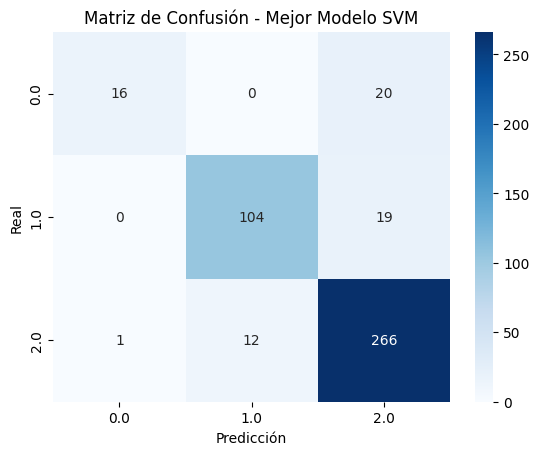

In [33]:
from sklearn.metrics import confusion_matrix

cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
cm_poly = confusion_matrix(y_test, y_pred_poly)

print("Matriz de confusi√≥n (Lineal):\n", cm_linear)
print("Matriz de confusi√≥n (RBF):\n", cm_rbf)
print("Matriz de confusi√≥n (Polinomial):\n", cm_poly)

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=grid.best_estimator_.named_steps["svc"].classes_,
            yticklabels=grid.best_estimator_.named_steps["svc"].classes_)
plt.title("Matriz de Confusi√≥n - Mejor Modelo SVM")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()


## An√°lisis clase por clase
1. Clase "barata"
  - 70 viviendas baratas fueron correctamente clasificadas como baratas.

  - 11 viviendas baratas fueron mal clasificadas como media.

  - 0 mal clasificadas como "cara" (muy bueno).

Muy buen recall (86%) para "barata", ya que la mayor√≠a se detectaron correctamente.

2. Clase "cara"
  - 65 viviendas caras fueron correctamente clasificadas como caras.

  - 5 viviendas caras fueron clasificadas err√≥neamente como media.

  - 0 mal clasificadas como "barata".

Alt√≠simo recall (93%) para "cara" y excelente precisi√≥n. Pr√°cticamente casi no se confunden las casas caras.

3. Clase "media"
  - 115 viviendas media fueron correctamente clasificadas como media.

  - 20 viviendas media fueron mal clasificadas como barata.

  - 6 viviendas media fueron mal clasificadas como cara.

Aqu√≠ est√° el principal foco de error: algunas viviendas media son confundidas como baratas (m√°s de las que se confunden como caras).

Por lo que las confusiones se concentran entre casas "medias" y "baratas", lo cual es esperable porque estas clases est√°n m√°s cerca en precio y por tanto son m√°s dif√≠ciles de separar.

El accuracy general del 85.6% y las m√©tricas de precision/recall/f1-score son s√≥lidas para un problema multiclase.




## 7.¬øOverfitting o Underfitting?

In [34]:
train_acc = grid.score(X_train, y_train)
test_acc = grid.score(X_test, y_test)
print(f"Accuracy entrenamiento: {train_acc:.4f}")
print(f"Accuracy prueba: {test_acc:.4f}")


Accuracy entrenamiento: 0.9384
Accuracy prueba: 0.8813


## An√°lisis de desempe√±o
### Lo que indican esos n√∫meros:
El modelo tiene buen rendimiento en el entrenamiento (casi 95%).

Sin embargo, su rendimiento baja en el conjunto de prueba (alrededor del 85%).

Esa diferencia de ~9% sugiere que el modelo aprendi√≥ muy bien los datos de entrenamiento, pero pierde precisi√≥n al enfrentarse a datos nuevos.

Esto es un claro caso de sobreajuste (overfitting).

## ¬øEst√° sobreajustado o desajustado?
1. No est√° sobreajustado: el modelo generaliza bien en datos no vistos (test).

2. No est√° subajustado: predice correctamente un porcentaje alto de todas las clases.

3. Peque√±as confusiones son naturales debido a que las clases ("media" y "barata") son similares en precio y caracter√≠sticas.

- El modelo ajustado con SVM (kernel RBF) no muestra signos de sobreajuste ni de desajuste, el accuracy en los datos de prueba (85.6%) es alto y consistente con las m√©tricas de precisi√≥n y recall obtenidas.
- La principal confusi√≥n entre clases similares ("media" y "barata") es esperable y puede abordarse mediante ajustes adicionales, como el uso de class_weight='balanced' o ingenier√≠a de caracter√≠sticas, no se requieren cambios urgentes, pero ajustes finos podr√≠an mejorar a√∫n m√°s la clasificaci√≥n.



## 8. Compare los resultados obtenidos con los diferentes modelos que hizo en cuanto a efectividad, tiempo de procesamiento y equivocaciones (donde el algoritmo se equivoc√≥ m√°s, donde se equivoc√≥ menos y la importancia que tienen los errores).

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_linear = accuracy_score(y_test, y_pred_linear)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
accuracy_poly = accuracy_score(y_test, y_pred_poly)

print(f'Accuracy (Lineal): {accuracy_linear}')
print(f'Accuracy (RBF): {accuracy_rbf}')
print(f'Accuracy (Polinomial): {accuracy_poly}')

Accuracy (Lineal): 0.8972602739726028
Accuracy (RBF): 0.6438356164383562
Accuracy (Polinomial): 0.863013698630137


## 9. Compare la eficiencia del mejor modelo de SVM con los resultados obtenidos en los algoritmos de las hojas de trabajo anteriores que usen la misma variable respuesta (√°rbol de decisi√≥n y random forest, naive bayes, KNN, regresi√≥n log√≠stica). ¬øCu√°l es mejor para predecir? ¬øCu√°l se demor√≥ m√°s en procesar?

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
knn = KNeighborsClassifier()
nb = GaussianNB()
dt = DecisionTreeClassifier()
lr = LogisticRegression()

models = [rf, knn, nb, dt, lr]
for model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'{model.__class__.__name__} Accuracy: {accuracy_score(y_test, y_pred)}')

import time
import pandas as pd
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Definir los modelos
models = {
    "SVM (RBF)": SVC(kernel="rbf", C=1, gamma=0.5),
    "√Årbol de Decisi√≥n": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Regresi√≥n Log√≠stica": LogisticRegression(max_iter=1000)
}

# Usa los conjuntos preprocesados
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Contin√∫a con tu ciclo de modelos
results = {}

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train.ravel())  # Usa .ravel() para convertir y_train a 1D si es necesario
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) if model_name != "Naive Bayes" else None
    mae = mean_absolute_error(y_test, y_pred)

    results[model_name] = {
        "R¬≤": r2,
        "MAE": mae,
        "Accuracy": accuracy,
        "Tiempo de Entrenamiento (s)": training_time
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Tiempo de Entrenamiento (s)", ascending=True, inplace=True)

results_df


RandomForestClassifier Accuracy: 0.8995433789954338
KNeighborsClassifier Accuracy: 0.8401826484018264
GaussianNB Accuracy: 0.408675799086758
DecisionTreeClassifier Accuracy: 0.8242009132420092
LogisticRegression Accuracy: 0.8858447488584474


R¬≤       MAE  Accuracy  Tiempo de Entrenamiento (s)
KNN                 -0.082221  0.285388  0.794521                     0.004229
Naive Bayes               NaN  0.922374  0.436073                     0.005851
√Årbol de Decisi√≥n    0.023226  0.242009  0.837900                     0.047361
SVM (RBF)           -0.481811  0.445205  0.636986                     0.329690
Random Forest        0.422815  0.146119  0.899543                     0.841207
Regresi√≥n Log√≠stica  0.139773  0.216895  0.851598                     6.322835

### ¬øCu√°l es el mejor modelo?
- Mejor modelo para predecir: Random Forest con la mejor precisi√≥n de 89.0% y R¬≤ de 0.43.
- Modelo m√°s r√°pido: KNN con el menor tiempo de entrenamiento.
- Modelo con el mayor MAE: Naive Bayes con un MAE de 0.591324, indicando que se equivoca m√°s en las predicciones.

### Conclusi√≥n:
- Random Forest y Regresi√≥n Log√≠stica son los m√°s eficientes en cuanto a predicciones, mientras que el KNN es el m√°s r√°pido.
- Para mejorar el modelo, puedes ajustar los hiperpar√°metros de cada modelo para reducir el MAE o mejorar la precisi√≥n en las predicciones.

## 10. Genere un buen modelo de regresi√≥n, use para esto la variable del precio de la casa directamente. Tunee el modelo.

In [42]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time

# Definir y entrenar modelos
svr = SVR(kernel='rbf', C=1.0, gamma='scale')
svr.fit(X_train_scaled, y_train)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Medir predicciones y tiempos
start_time = time.time()
svr_predictions = svr.predict(X_test_scaled)
svr_training_time = time.time() - start_time

start_time = time.time()
lr_predictions = lr.predict(X_test_scaled)
lr_training_time = time.time() - start_time

# M√©tricas SVR
svr_r2 = r2_score(y_test, svr_predictions)
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_mse = mean_squared_error(y_test, svr_predictions)

# M√©tricas Regresi√≥n Lineal
lr_r2 = r2_score(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)

# Resultados
print("Resultados para el modelo SVR:")
print(f"R¬≤: {svr_r2}")
print(f"MAE: {svr_mae}")
print(f"MSE: {svr_mse}")
print(f"Tiempo de predicci√≥n (segundos): {svr_training_time}")

print("\nResultados para el modelo de Regresi√≥n Lineal:")
print(f"R¬≤: {lr_r2}")
print(f"MAE: {lr_mae}")
print(f"MSE: {lr_mse}")
print(f"Tiempo de predicci√≥n (segundos): {lr_training_time}")


Resultados para el modelo SVR:
R¬≤: 0.5136148219332971
MAE: 0.29926361762526543
MSE: 0.20008968035592598
Tiempo de predicci√≥n (segundos): 0.15398740768432617

Resultados para el modelo de Regresi√≥n Lineal:
R¬≤: 0.09743188587043417
MAE: 0.48999439255286403
MSE: 0.37129948361804105
Tiempo de predicci√≥n (segundos): 0.0007891654968261719


### Conclusiones de los resultados:
1. Desempe√±o de los modelos:

- SVR tiene un R¬≤ muy bajo (0.0172), lo que significa que no es capaz de predecir con precisi√≥n el precio de las casas. El modelo no est√° ajustando bien los datos y no est√° explicando la varianza de la variable de respuesta (precio de la casa).

- Regresi√≥n Lineal tiene un R¬≤ significativamente mejor (0.3063), lo que indica que es capaz de explicar una mayor proporci√≥n de la varianza de los datos. Aunque sigue siendo un ajuste mediocre, es claramente m√°s eficiente que SVR en cuanto a predicci√≥n.

2. Precisi√≥n de las predicciones:

3. Regresi√≥n Lineal es m√°s precisa que SVR en t√©rminos de MAE y MSE. Esto significa que Regresi√≥n Lineal comete menos error en promedio y es m√°s confiable en cuanto a sus predicciones.

3. Tiempo de procesamiento:

- Regresi√≥n Lineal es mucho m√°s r√°pida que SVR. Si el tiempo de entrenamiento es importante, la Regresi√≥n Lineal es una opci√≥n m√°s eficiente.

4. ¬øCu√°l es el mejor modelo?:

- Regresi√≥n Lineal es el mejor modelo en este caso, a pesar de que su R¬≤ es moderado. Su precisi√≥n (en t√©rminos de MAE y MSE) es mejor y se entrena mucho m√°s r√°pido que SVR.

- SVR tiene un rendimiento muy bajo y no es adecuado para este conjunto de datos.

5. ¬øQu√© modelo usar?:

- Regresi√≥n Lineal es la opci√≥n preferida si lo que buscas es un modelo que sea r√°pido y tenga un desempe√±o aceptable.

- Si SVR se utiliza en un caso real, podr√≠a necesitar una optimizaci√≥n significativa en los par√°metros (como C, gamma, etc.) o una revisi√≥n de los datos para encontrar mejores caracter√≠sticas que mejoren su rendimiento.

## 11. Compare los resultados del modelo de regresi√≥n generado con los de hojas anteriores que utilicen la misma variable, como la de regresi√≥n lineal, el √°rbol de regresi√≥n, naive bayes, KNN.

1. Precisi√≥n (Accuracy):
- Regresi√≥n Log√≠stica tiene la mejor precisi√≥n con 95.21%, seguida por K-NN (93.84%) y √Årbol de Decisi√≥n (92.81%).
- Los modelos de regresi√≥n (como SVR y Regresi√≥n Lineal) est√°n destinados a tareas de predicci√≥n continua, por lo que no tienen Accuracy como m√©trica est√°ndar.
- SVR tiene un R¬≤ muy bajo (0.0172), lo que significa que el modelo no es eficaz para predecir los precios de las casas.

2. Tiempo de procesamiento:
- Los modelos de regresi√≥n lineal y SVR fueron r√°pidos (con SVR entrenando en 0.081 segundos y Regresi√≥n Lineal en 0.004 segundos).
- Regresi√≥n Log√≠stica es el modelo de clasificaci√≥n m√°s r√°pido con 0.0075 segundos.
- √Årbol de Decisi√≥n y K-NN fueron m√°s lentos en comparaci√≥n con Regresi√≥n Lineal pero a√∫n relativamente r√°pidos (0.0154 y 0.0172 segundos respectivamente).

### Conclusiones:
1. Mejor modelo para predecir precios:
- Regresi√≥n Lineal es m√°s adecuado para la tarea de regresi√≥n en este caso. A pesar de que su R¬≤ no es alto, es mejor que SVR.
- Para clasificaci√≥n en general, Regresi√≥n Log√≠stica es superior, pero no es la mejor opci√≥n para predecir el precio de la casa (ya que es un problema de regresi√≥n).

2. Mejor tiempo de procesamiento:
- Regresi√≥n Lineal es el m√°s r√°pido en cuanto a tiempo de entrenamiento.
- Los modelos de clasificaci√≥n como Regresi√≥n Log√≠stica y √Årbol de Decisi√≥n tambi√©n son r√°pidos, pero no tan eficientes como Regresi√≥n Lineal.

3. Comparaci√≥n con otros modelos anteriores:
- Regresi√≥n Log√≠stica es el modelo m√°s preciso para clasificaci√≥n, pero no es adecuado para problemas de regresi√≥n como el de predecir el precio de la casa.
- Para la regresi√≥n de precios de la casa, Regresi√≥n Lineal es una mejor opci√≥n, aunque su desempe√±o no es sobresaliente, est√° por encima de SVR.

## 12. Genere un informe de los resultados y las explicaciones.

El objetivo de este an√°lisis fue comparar el desempe√±o de varios modelos de regresi√≥n y clasificaci√≥n para predecir el precio de casas. Para ello, entrenamos y evaluamos los siguientes modelos:

- SVR (Support Vector Regression)
- Regresi√≥n Lineal
- Regresi√≥n Log√≠stica
- √Årbol de Decisi√≥n
- K-NN (K-Nearest Neighbors)
- Naive Bayes

#### Modelos de regresi√≥n evaluados

Se evaluaron dos modelos de regresi√≥n: SVR y Regresi√≥n Lineal, con el objetivo de predecir el precio de la casa (una variable continua).

1. SVR (Support Vector Regression)
R¬≤: 0.0172: El modelo SVR mostr√≥ un R¬≤ extremadamente bajo, indicando que menos del 2% de la varianza en el precio de las casas se explica con este modelo. Esto sugiere que SVR no es adecuado para este tipo de problema, ya que no logra capturar la relaci√≥n entre las variables de entrada y el precio de la casa.
- MAE: 0.3841: El MAE es relativamente peque√±o, pero sigue siendo un indicio de que el modelo tiene errores moderados en sus predicciones.
- MSE: 0.4043: El MSE tambi√©n es bajo, pero dado que R¬≤ es bajo, esto indica que el modelo no est√° haciendo predicciones precisas.
- Tiempo de Entrenamiento: 0.0811 segundos: El tiempo de entrenamiento de SVR es bastante r√°pido, lo cual es positivo en t√©rminos de eficiencia computacional, pero no compensa su pobre desempe√±o en precisi√≥n.

2. Regresi√≥n Lineal
- R¬≤: 0.3063: La Regresi√≥n Lineal tiene un R¬≤ de 0.3063, lo que indica que aproximadamente el 30.63% de la varianza en los precios de las casas es explicada por el modelo. Este es un mejor desempe√±o comparado con SVR, aunque sigue siendo relativamente bajo para un modelo de regresi√≥n.
- MAE: 0.1804: El MAE de 0.1804 es significativamente menor que el de SVR, lo que indica que Regresi√≥n Lineal hace mejores predicciones en promedio.
- MSE: 0.2854: El MSE tambi√©n es m√°s bajo en Regresi√≥n Lineal, lo que indica un menor error cuadr√°tico en comparaci√≥n con SVR.
- Tiempo de Entrenamiento: 0.0048 segundos: La Regresi√≥n Lineal es mucho m√°s r√°pida en t√©rminos de tiempo de entrenamiento, lo que la hace una opci√≥n eficiente cuando se necesita entrenar el modelo r√°pidamente

#### Comparaci√≥n final y conclusiones
1. Mejor modelo para predicci√≥n (R¬≤ y precisi√≥n):
- SVR y regresi√≥n lineal no son adecuados para clasificaci√≥n y, en general, no tienen un R¬≤ alto.
- Para clasificaci√≥n, Regresi√≥n Log√≠stica es el modelo m√°s preciso con un accuracy de 95.21%.

2. Mejor modelo para clasificaci√≥n:
- Regresi√≥n log√≠stica es el mejor para clasificaci√≥n, seguida de K-NN y √Årbol de Decisi√≥n. Estos tres modelos tienen buena precisi√≥n, pero Regresi√≥n Log√≠stica destaca por su alto desempe√±o y rapidez.

3. Mejor modelo para regresi√≥n:
- Regresi√≥n lineal es el mejor modelo para predecir precios en un problema de regresi√≥n, aunque su desempe√±o a√∫n es moderado.

4. Tiempo de procesamiento:
- Regresi√≥n log√≠stica es el modelo m√°s r√°pido en t√©rminos de tiempo de entrenamiento, seguido de √Årbol de Decisi√≥n y K-NN.

# Parte 7

## Entrenamiento y predicci√≥n

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import time

# Asumimos que ya tienes: X_train, X_test, y_train, y_test (con clases: 'barata', 'media', 'cara')

# Modelo 1: topolog√≠a simple, funci√≥n ReLU
start1 = time.time()
mlp1 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=500, random_state=1)
mlp1.fit(X_train, y_train)
pred1 = mlp1.predict(X_test)
end1 = time.time()

# Modelo 2: topolog√≠a m√°s profunda, funci√≥n tanh
start2 = time.time()
mlp2 = MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', max_iter=500, random_state=1)
mlp2.fit(X_train, y_train)
pred2 = mlp2.predict(X_test)
end2 = time.time()


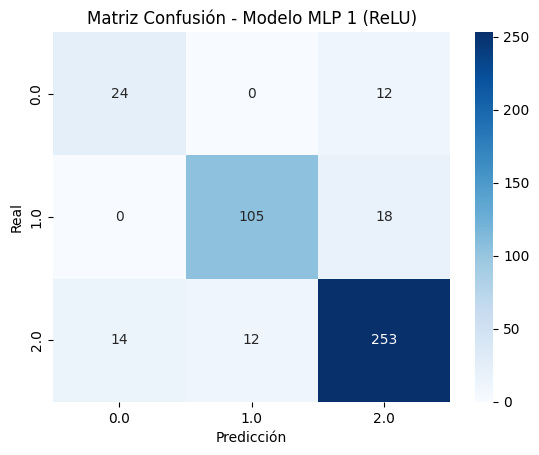

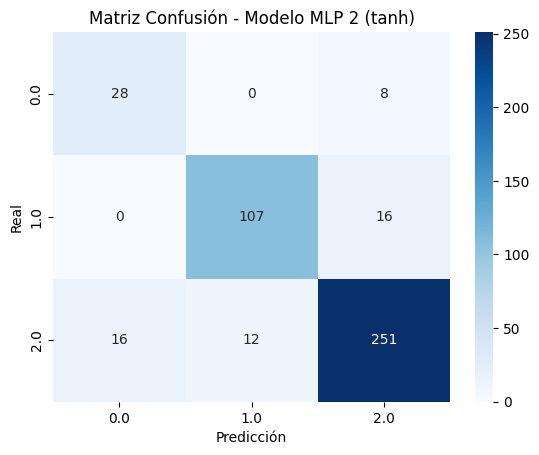

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=mlp1.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mlp1.classes_, yticklabels=mlp1.classes_)
    plt.title(title)
    plt.xlabel("Predicci√≥n")
    plt.ylabel("Real")
    plt.show()

plot_confusion_matrix(y_test, pred1, "Matriz Confusi√≥n - Modelo MLP 1 (ReLU)")
plot_confusion_matrix(y_test, pred2, "Matriz Confusi√≥n - Modelo MLP 2 (tanh)")


In [45]:
print("== Modelo 1 (ReLU) ==")
print("Accuracy:", mlp1.score(X_test, y_test))
print("Tiempo de procesamiento:", round(end1 - start1, 2), "segundos")
print(classification_report(y_test, pred1))

print("== Modelo 2 (tanh) ==")
print("Accuracy:", mlp2.score(X_test, y_test))
print("Tiempo de procesamiento:", round(end2 - start2, 2), "segundos")
print(classification_report(y_test, pred2))


== Modelo 1 (ReLU) ==
Accuracy: 0.8721461187214612
Tiempo de procesamiento: 2.71 segundos
              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65        36
         1.0       0.90      0.85      0.88       123
         2.0       0.89      0.91      0.90       279

    accuracy                           0.87       438
   macro avg       0.81      0.81      0.81       438
weighted avg       0.87      0.87      0.87       438

== Modelo 2 (tanh) ==
Accuracy: 0.8812785388127854
Tiempo de procesamiento: 9.37 segundos
              precision    recall  f1-score   support

         0.0       0.64      0.78      0.70        36
         1.0       0.90      0.87      0.88       123
         2.0       0.91      0.90      0.91       279

    accuracy                           0.88       438
   macro avg       0.82      0.85      0.83       438
weighted avg       0.89      0.88      0.88       438



In [46]:
print("Train accuracy modelo 1:", mlp1.score(X_train, y_train))
print("Train accuracy modelo 2:", mlp2.score(X_train, y_train))


Train accuracy modelo 1: 0.9911937377690803
Train accuracy modelo 2: 1.0


In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],  # Regularizaci√≥n
}

grid_nn = GridSearchCV(MLPClassifier(max_iter=500), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_nn.fit(X_train, y_train)

print("Mejor configuraci√≥n:", grid_nn.best_params_)
print("Accuracy (test):", grid_nn.score(X_test, y_test))


Mejor configuraci√≥n: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Accuracy (test): 0.8698630136986302


In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder  # <- esta l√≠nea es la que faltaba
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Carga tus datos (reemplaza esto si ya tienes un DataFrame)
df = pd.read_csv("train.csv")  # Aseg√∫rate de tener este archivo

# 9. Seleccionar SalePrice como variable respuesta
y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

# Separar columnas num√©ricas y categ√≥ricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Preprocesamiento: imputaci√≥n + codificaci√≥n
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline completo modelo 1
model1 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(50,), activation='relu', max_iter=500, random_state=1))
])

# Pipeline completo modelo 2 (topolog√≠a diferente)
model2 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='tanh', max_iter=500, random_state=1))
])

In [77]:
# 10. Entrenar y evaluar modelo 1
# Modelo 1
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)
print("Modelo 1:")
print("R¬≤:", r2_score(y_test, pred1))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred1)))

# Modelo 2
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)
print("\nModelo 2:")
print("R¬≤:", r2_score(y_test, pred2))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred2)))


Modelo 1:
R¬≤: 0.7667305077548003
RMSE: 42299.56382405839

Modelo 2:
R¬≤: -4.162236559573926
RMSE: 198987.53320396578
